# AI for AC Optimal Power Flow

[![Python 3.8+](https://img.shields.io/badge/python-3.8+-blue.svg)](https://www.python.org/downloads/)
[![PyTorch](https://img.shields.io/badge/PyTorch-1.9+-red.svg)](https://pytorch.org/)

We use neural networks to predict the best way to control power flow in an electrical grid. This makes finding solutions faster and easier, even when the grid is complex. If you would like to know more about problem that we are solving and its impact read [Intro](./intro_and_theory.md).

# Table of Contents

*   [Software Requirements](#software-requirements)
*   [Case Study: PJM 5 network](#pjm-case-study)
*   [Machine Learning for ACOPF](#ml-for-ac-opf)
*   [Data](#data)
*   [Case Study: NN for ACOPF](#nn-for-acopf)
*   [Results & Discussion](#results-and-discussion)

<a id='software-requirements'></a>
# Software Requirements
The Python version at the time of this submission = Python 3.12.13

The following libraries are required:
*   pandas
*   numpy
*   matplotlib
*   pypower
*   pytorch

In [1]:
!python --version

Python 3.10.12


In [2]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

# Deep learning framework
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# For reproducibility
SEED = 2024
torch.manual_seed(SEED)

<a id="pjm-case-study"></a>

## Case Study: PJM 5 network

The [PJM 5-bus system](https://github.com/power-grid-lib/pglib-opf/blob/master/pglib_opf_case5_pjm.m), which includes information on suggested generation bids, generation megawatt (MW) limits, and MW loads, was initially released in 1999 by PJM as a part of their training resources. Since then, multiple revised versions of the system have been implemented while retaining the fundamental system configuration.
More test cases can be found in [Power Grid Lib](https://power-grid-lib.github.io/), ranging from 3-bus to 78484-bus networks.

![PJM case](./assets/images/pjm_case.png)

The system is a 5-bus grid with two major zones divided into generation and loads. As you can see from the figure, the nodes represent cities in Utah, MI, in the US. The case file includes a snapshot of the grid including the necessary parameters to calculate a(n) (optimal) power flow calculation. Let's analyze the data step-by-step.

In [4]:
# Load the network for Case5
net = {
    "baseMVA": 100.0,
## area data
    "areas": np.array([[1, 4]]),
## bus data
###	bus_i	type	Pd	Qd	Gs	Bs	area	Vm	Va	baseKV	zone	Vmax	Vmin
    "bus": np.array([
            [1, 2, 0.0, 0.0, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [2, 1, 300.0, 98.61, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [3, 2, 300.0, 98.61, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [4, 3, 400.0, 131.47, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [5, 2, 0.0, 0.0, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000]
        ]),
## generator data
###	bus	Pg	Qg	Qmax	Qmin	Vg	mBase	status	Pmax	Pmin
    "gen": np.array([
            [1, 20.0, 0.0, 30.0, -30.0, 1.0, 100.0, 1, 40.0, 0.0],
            [1, 85.0, 0.0, 127.5, -127.5, 1.0, 100.0, 1, 170.0, 0.0],
            [3, 260.0, 0.0, 390.0, -390.0, 1.0, 100.0, 1, 520.0, 0.0],
            [4, 100.0, 0.0, 150.0, -150.0, 1.0, 100.0, 1, 200.0, 0.0],
            [5, 300.0, 0.0, 450.0, -450.0, 1.0, 100.0, 1, 600.0, 0.0]
        ]),
## generator cost data
###	2	startup	shutdown	n	c(n-1)	...	c0
    "gencost": np.array([
            [2, 0.0, 0.0, 3, 0.000000, 14.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 15.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 30.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 40.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 10.000000, 0.000000]
        ]),
## branch data
###	fbus	tbus	r	x	b	rateA	rateB	rateC	ratio	angle	status	angmin	angmax
    "branch": np.array([
            [1, 2, 0.00281, 0.0281, 0.00712, 400.0, 400.0, 400.0, 0.0, 0.0, 1, -30.0, 30.0],
            [1, 4, 0.00304, 0.0304, 0.00658, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [1, 5, 0.00064, 0.0064, 0.03126, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [2, 3, 0.00108, 0.0108, 0.01852, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [3, 4, 0.00297, 0.0297, 0.00674, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [4, 5, 0.00297, 0.0297, 0.00674, 240.0, 240.0, 240.0, 0.0, 0.0, 1, -30.0, 30.0]
        ])
}

In [5]:
bus = pd.DataFrame(net['bus'],
                   columns=['bus_i', 'type',	'Pd',	'Qd',	'Gs',	'Bs',
                            'area',	'Vm',	'Va',	'baseKV',	'zone',	'Vmax',	'Vmin'])
nbus = len(bus)
bus

,bus_i,type,Pd,Qd,Gs,Bs,area,Vm,Va,baseKV,zone,Vmax,Vmin
0,1.0,2.0,0.0,0.00,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
1,2.0,1.0,300.0,98.61,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
2,3.0,2.0,300.0,98.61,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
3,4.0,3.0,400.0,131.47,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
4,5.0,2.0,0.0,0.00,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9


There are 5 buses in the system, all of them on the same voltage level at 230 kV and in the same zone (1). The voltage can oscillate between 0.9 and 1.1 per unit. (Note: <i>per unit</i> is a type of measurement unit used to express quantities in power systems; we won't get into the details of this measurement system here.)

There are 3 loads with active (MW) and reactive (VAr) power. The biggest is the load at bus 3 with a maximum power consumption of 400 MW.

In [6]:
gen = pd.DataFrame(net['gen'],
                   columns = ['bus',	'Pg',	'Qg',
                              'Qmax',	'Qmin',	'Vg',
                              'mBase',	'status',	'Pmax',	'Pmin'])
gen

,bus,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin
0,1.0,20.0,0.0,30.0,-30.0,1.0,100.0,1.0,40.0,0.0
1,1.0,85.0,0.0,127.5,-127.5,1.0,100.0,1.0,170.0,0.0
2,3.0,260.0,0.0,390.0,-390.0,1.0,100.0,1.0,520.0,0.0
3,4.0,100.0,0.0,150.0,-150.0,1.0,100.0,1.0,200.0,0.0
4,5.0,300.0,0.0,450.0,-450.0,1.0,100.0,1.0,600.0,0.0


Then, we see the generators with different maximum levels of active and reactive power. Notice that the bus variables indicate where the generator is connected on the grid.

In [7]:
line = pd.DataFrame(net['branch'],
                    columns = ['fbus',	'tbus',	'r',	'x',	'b',
                               'rateA',	'rateB',	'rateC',	'ratio',
                               'angle',	'status',	'angmin',	'angmax'] )
line

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,1.0,2.0,0.00281,0.0281,0.00712,400.0,400.0,400.0,0.0,0.0,1.0,-30.0,30.0
1,1.0,4.0,0.00304,0.0304,0.00658,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
2,1.0,5.0,0.00064,0.0064,0.03126,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
3,2.0,3.0,0.00108,0.0108,0.01852,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
4,3.0,4.0,0.00297,0.0297,0.00674,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
5,4.0,5.0,0.00297,0.0297,0.00674,240.0,240.0,240.0,0.0,0.0,1.0,-30.0,30.0


Now, we have 6 lines connecting `from_bus` to `to_bus` with some specific parameters, e.g. resistance (`r`) and reactance (`x`).

In [8]:
gen_cost = pd.DataFrame(net['gencost'],
                        columns = ['order_poly', 'startup', 'shutdown', 'num_coefficient', 'c2', 'c1', 'c0'])
gen_cost

,order_poly,startup,shutdown,num_coefficient,c2,c1,c0
0,2.0,0.0,0.0,3.0,0.0,14.0,0.0
1,2.0,0.0,0.0,3.0,0.0,15.0,0.0
2,2.0,0.0,0.0,3.0,0.0,30.0,0.0
3,2.0,0.0,0.0,3.0,0.0,40.0,0.0
4,2.0,0.0,0.0,3.0,0.0,10.0,0.0


Up until this point, the grid data is static just as a snapshot, and includes data for all parameters, e.g., minimum and maximum voltage at each node, minimum and maximum active and reactive power generation, generation costs, etc.

After looking at the data, we can solve the AC-OPF problem over this power grid configuration. We use [PyPower](https://rwl.github.io/PYPOWER/api/), a Python-based power system solver, to solve the complex AC-OPF problem.

In [9]:
# import the solver and solver options from pypower
from pypower.api import runopf, ppoption

# Run power flow to get results
option = ppoption(OUT_ALL=-1) # set the output details
result = runopf(net, option) # run the ACOPF

PYPOWER Version 5.1.18, 10-Apr-2025 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.37 seconds
Objective Function Value = 17551.89 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              5     Total Gen Capacity    1530.0       -1147.5 to 1147.5
Generators         5     On-line Capacity      1530.0       -1147.5 to 1147.5
Committed Gens     5     Generation (actual)   1005.2             371.7
Loads              3     Load                  1000.0             328.7
  Fixed            3       Fixed               1000.0             328.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           6     Losses (I^2 * Z)     

It take about 0.5 second to find the optimal solution to AC-OPF. The detailed results are shown above, including the active/reactive power generation at each generator, the voltage magnitude and voltage angle at each bus, the active/reactive power flow over branches, and the generation costs.

Now that we solved AC-OPF for a specific case on a specific power grid, we can now think about other consumption cases. As we know, we don't consume the same level of electricity at our houses all the time, and the same happens at industrial facilities or with public lighting. The grid is always changing and every second the grid operator must balance the generation with the consumption to keep the grid stable. Given that the real-world grid is very very big and complex, the solution of the AC-OPF becomes cumbersome as the complexity of the problem increases, and the computation needed to solve it is very high.


<a id='ml-for-ac-opf'></a>
# Machine Learning for AC-OPF


Another idea would be to use an abstract function approximation which solves the problem for us in much less time than the actual optimization problem as the ACOPF. 

Thanks to recent advances in Machine Learning, we can make use of different algorithms to do this. In this tutorial we will use a Neural Network to predict the ACOPF solution.


The use of machine learning (ML) for solving AC-OPF is an evolving area of research that promises to enhance the efficiency and effectiveness of power grid operations.

## Motivation for Using ML

Since the grid operators need to actively manage the power grid to prevent congestion or even blackouts, there is a need for quicker solvers or approximations to the AC-OPF.

Traditional methods for solving the ACOPF, such as interior point methods, while effective, often encounter challenges related to computational complexity, especially in large-scale grids or under dynamic conditions. These methods can be computationally intensive and slow, which limits their practicality for real-time operations and rapid decision-making required in modern power systems, particularly those integrating variable renewable energy sources.

How about using machine learning to accelerate the solving process? For example, we can use a neural network to directly predict the optimal solution (i.e., power generation, voltage, ...) given the input parameters (i.e., electricity demand).

![use of ml](./assets/images/use_of_ml.png)

We follow a supervised learning scheme to train the neural network. To do this, we first need to prepare a training dataset.

<a id="data"></a>
## Import Prepared Training Data

The dataset contains different load profiles and their respective optimal solutions. More information on the dataset creation method can be found in the publication, "OPF-Learn: An Open-Source Framework for Creating Representative AC Optimal Power Flow Datasets" and in the package website: [OPFLearn.jl](https://github.com/NREL/OPFLearn.jl) and [OPFLearnData](https://data.nrel.gov/submissions/177).

### Data Download

The following bash script downloads the .csv file from the Case 5 power grid and saves it to a data folder.

In [10]:
# Download data
!mkdir data
!wget https://data.nrel.gov/system/files/177/pglib_opf_case5_pjm.csv -P data/

mkdir: cannot create directory ‘data’: File exists
--2025-08-12 20:36:31--  https://data.nrel.gov/system/files/177/pglib_opf_case5_pjm.csv
Resolving data.nrel.gov (data.nrel.gov)... 76.223.107.85, 13.248.240.147
Connecting to data.nrel.gov (data.nrel.gov)|76.223.107.85|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nrel-datacat-public-prod.s3.us-west-2.amazonaws.com/files/177/pglib_opf_case5_pjm.csv?response-content-disposition=attachment%3B%20filename%3Dpglib_opf_case5_pjm.csv&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Security-Token=IQoJb3JpZ2luX2VjENP%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJHMEUCIDjRLqFlxdEGROw0SQEuvax7RfkZFdblEuM8nD1173GrAiEAkMxjkSTsvO3tjE5BsLRUM%2FLfQmx3vOnaYrKOqwnAh7Uq5QMIHBAAGgw5OTE0MDQ5NTYxOTQiDJoDTHWE7tln3kksRyrCAy7iGV94oC%2F1%2FUg5FJ2uJlXj1%2FIjZih4N%2Ff43tUBKVL6wNxdeEsKwRUIKCPMpQrxhYvsYSr2XvaPLRl5866dQ%2FL8yMlHw2UsqqqtGU5d8ISB0Md3OadHwb7cmDCbNuGtXmeZMrGfjY1umFk0ii4uqW5SJjWI5UW8VG6P6PSsLFm50KzYnDA5T0sbnVW7RYaR2O

### Data Exploration
Now, we will look into the data that we downloaded. Take into account that this dataset is specific for a grid called Case 5 from an energy market in the US called PJM. This will be explained in the next section. For now, let's focus on getting a glimpse of the data.

In [11]:
df = pd.read_csv('data/pglib_opf_case5_pjm.csv')
df.head()

,load1:pl,load2:pl,load3:pl,load1:ql,load2:ql,load3:ql,gen1:pg,gen2:pg,gen3:pg,gen4:pg,...,line3:p_fr_max,line4:p_fr_max,line5:p_fr_max,line6:p_fr_max,line1:q_fr_max,line2:q_fr_max,line3:q_fr_max,line4:q_fr_max,line5:q_fr_max,line6:q_fr_max
0,6.570765,2.275993,4.051883,4.376283,0.628149,4.026378,0.4,1.7,4.876424,1.558644,...,-0.000002,-0.000003,-2.720498e-07,-0.000006,0.000000e+00,0.0,-7.933284e-07,-1.873404e-06,0.0,-3.069352e-06
1,6.552550,1.704638,4.090173,4.400894,0.724693,3.937011,0.4,1.7,4.317437,1.531758,...,-0.000002,-0.000003,-2.624331e-07,-0.000006,0.000000e+00,0.0,-7.848656e-07,-1.892890e-06,0.0,-2.936123e-06
2,5.645406,2.029723,5.955067,1.377338,0.865517,3.240306,0.4,1.7,5.199999,1.490930,...,-0.000002,-0.000002,0.000000e+00,-0.000280,-1.365476e-07,0.0,0.000000e+00,-8.479213e-07,0.0,-3.177477e-07
3,4.778645,2.417017,6.361179,0.843277,0.881531,2.635903,0.4,1.7,5.200000,1.644658,...,-0.000001,-0.000001,0.000000e+00,-0.647117,-3.141235e-07,0.0,0.000000e+00,-7.238938e-07,0.0,-6.550166e-09
4,5.690040,2.458801,5.745494,2.003454,1.119158,3.286294,0.4,1.7,5.200000,1.684051,...,-0.000002,-0.000002,-5.028490e-09,-0.000067,0.000000e+00,0.0,0.000000e+00,-9.201327e-07,0.0,-6.686726e-07


In [12]:
df.shape

(10000, 104)

In [13]:
df.columns

Index(['load1:pl', 'load2:pl', 'load3:pl', 'load1:ql', 'load2:ql', 'load3:ql',
       'gen1:pg', 'gen2:pg', 'gen3:pg', 'gen4:pg',
       ...
       'line3:p_fr_max', 'line4:p_fr_max', 'line5:p_fr_max', 'line6:p_fr_max',
       'line1:q_fr_max', 'line2:q_fr_max', 'line3:q_fr_max', 'line4:q_fr_max',
       'line5:q_fr_max', 'line6:q_fr_max'],
      dtype='object', length=104)

We can see that this is a dataset of 10000 rows by 104 columns. Each row represents the feature and solution of the AC-OPF. Let's define the inputs and outputs for the machine learning model based on the AC-OPF formulation from [here](./intro_and_theory.md).

For example, columns 0:3 represent the active power consumption for the loads, while columns 3:6 represent the reactive power consumption of the loads. We can now separate them into a variable called `inputs`, which means they are the input parameters for the AC-OPF problem.

In [14]:
# Define input columns
load_p = list(df.columns[0:3])
load_q = list(df.columns[3:6])
inputs = load_p + load_q
print(inputs)

['load1:pl', 'load2:pl', 'load3:pl', 'load1:ql', 'load2:ql', 'load3:ql']


Now, we can do the same with the outputs, i.e., the optimal solution for the AC-OPF problem given load demand, which includes the active and reactive power at each generator as well as the voltage magnitude and angle at each bus.

In [15]:
# Define output columns
gen_p = list(df.columns[6:11])
gen_q = list(df.columns[11:16])
def convert(x):
    # Remove spaces around the '+' or '-' before 'j'
    x = x.replace(" + ", "+").replace(" - ", "-").replace("j", "j").strip()
    return np.complex64(x)
bus_vm = []
bus_va = []
for bus_v_column in df.columns[21:26]:
  df[bus_v_column + '_mag'] = df[bus_v_column].apply(convert).apply(np.abs)
  bus_vm.append(bus_v_column + '_mag')
  df[bus_v_column + '_ang'] = df[bus_v_column].apply(convert).apply(np.angle)
  ## the follow line of code is to correct a bug in the OPFLearn dataset
  df[bus_v_column + '_ang'] = -1*np.rad2deg(df[bus_v_column + '_ang'].values)
  bus_va.append(bus_v_column + '_ang')
outputs = gen_p + gen_q + bus_vm + bus_va
print(outputs)

['gen1:pg', 'gen2:pg', 'gen3:pg', 'gen4:pg', 'gen5:pg', 'gen1:qg', 'gen2:qg', 'gen3:qg', 'gen4:qg', 'gen5:qg', 'bus1:v_bus_mag', 'bus2:v_bus_mag', 'bus3:v_bus_mag', 'bus4:v_bus_mag', 'bus5:v_bus_mag', 'bus1:v_bus_ang', 'bus2:v_bus_ang', 'bus3:v_bus_ang', 'bus4:v_bus_ang', 'bus5:v_bus_ang']


Now that we separated the data into inputs and outputs, let's take a look into each of those columns. The following function plots the histogram of each variable, so it takes the whole 10000 samples for each variable and plots the distribution. On the x-axis we see the variable value, and on the y axis the frequency of samples that fit into a specific bucket or bin. We will be using 10 bins just to get an idea of the shape of the distribution. Notice that we are also annotating the mean of all the samples in black.

In [16]:
def plot_hist_variables(variables):
    fig, axs = plt.subplots(nrows=1, ncols=len(variables), figsize=(16, 3))
    for i, input_name in enumerate(variables):
        axs[i].hist(df[input_name], bins=10, density=True)
        axs[i].set_title(input_name, fontsize=18)
        mean_value = df[input_name].mean()
        axs[i].axvline(mean_value, color='k', linestyle='dashed', linewidth=2)
        x_offset = axs[i].get_xlim()[1] * 0.02
        y_offset = axs[i].get_ylim()[1] * 0.05
        axs[i].annotate(f"Mean: {mean_value:.2f}", xy=(mean_value, axs[i].get_ylim()[1]),
                        xytext=(mean_value+x_offset, axs[i].get_ylim()[1]-y_offset),
                        ha='left', va='top', fontsize=14,
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        if 'pl' in input_name: axs[i].set_xlabel('active load (p.u.)', fontsize=14)
        elif 'ql' in input_name: axs[i].set_xlabel('reactive load (p.u.)', fontsize=14)
        elif 'pg' in input_name: axs[i].set_xlabel('active gen (p.u.)', fontsize=14)
        elif 'qg' in input_name: axs[i].set_xlabel('reactive gen (p.u.)', fontsize=14)
        elif 'mag' in input_name: axs[i].set_xlabel('bus vol. mag. (p.u.)', fontsize=14)
        elif 'ang' in input_name: axs[i].set_xlabel('bus vol. ang. (rad.)', fontsize=14)
    fig.tight_layout()
    plt.show()

#### Inputs

**Active** & **Reactive** power of each load:

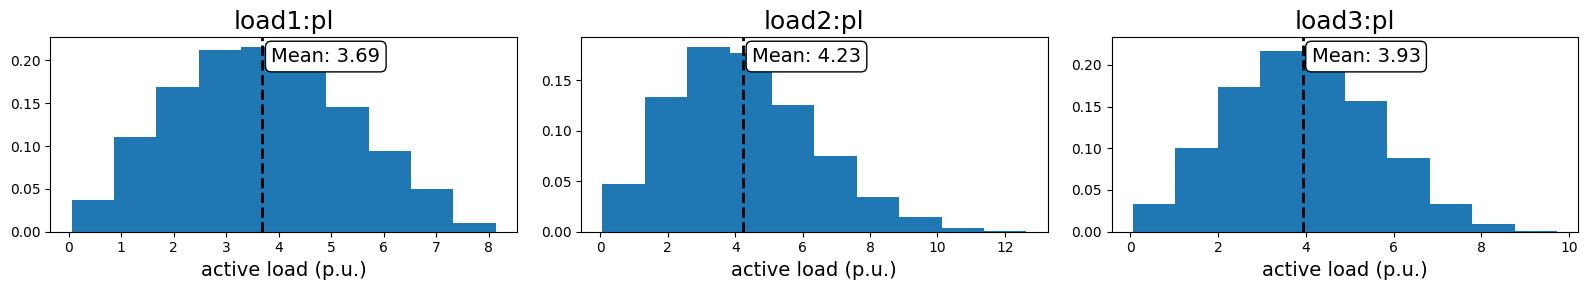

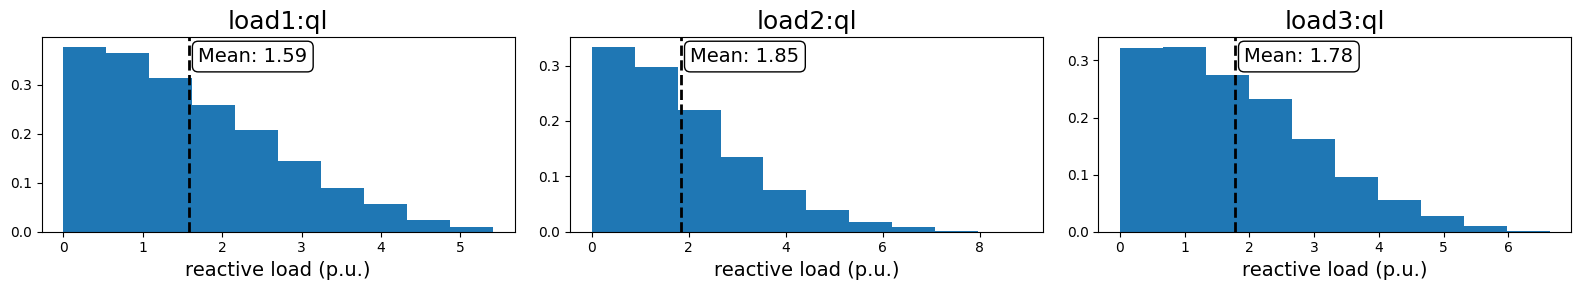

In [17]:
plot_hist_variables(load_p)
plot_hist_variables(load_q)

The shapes of the distributions of both variables are a bit different, where active power can be generalized as a `Normal` distribution, while the reactive power looks like an `Exponential` or `Log(Normal)` distribution.

#### Outputs

**Active** & **Reactive** power of each generator:

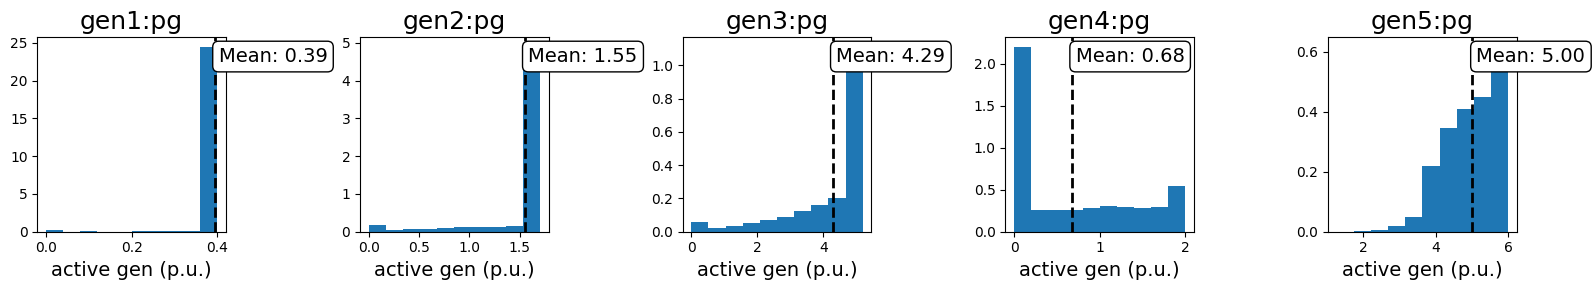

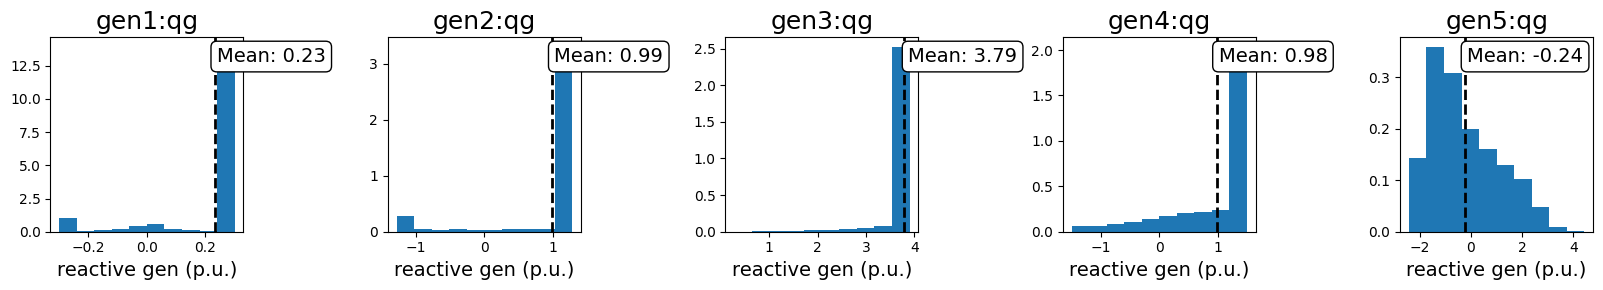

In [18]:
plot_hist_variables(gen_p)
plot_hist_variables(gen_q)

Voltage **Mangnitude** & **Angle** at each bus:

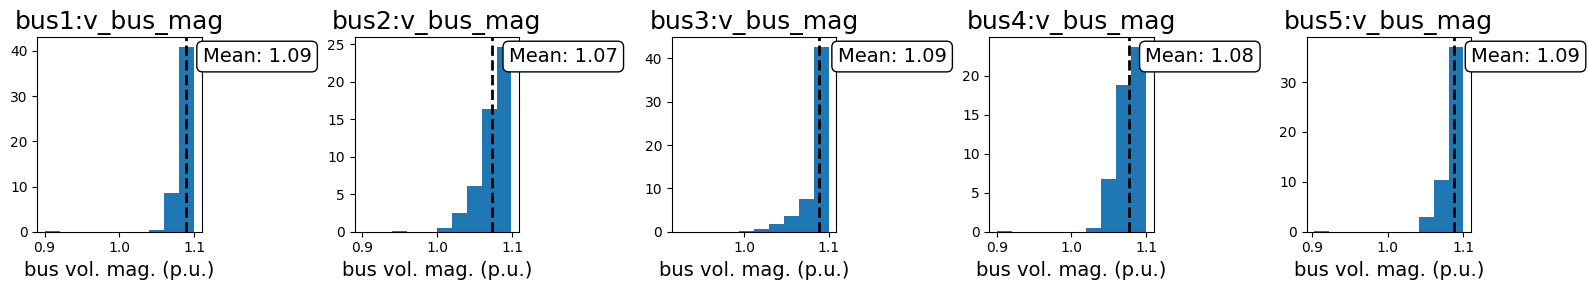

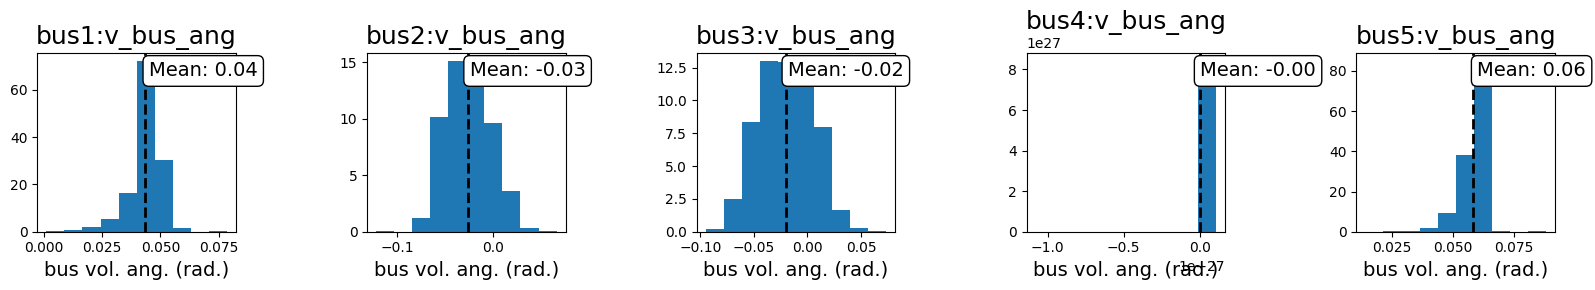

In [19]:
plot_hist_variables(bus_vm)
plot_hist_variables(bus_va)

In the case of the generations, we can see that generators' setpoints are set almost always at the same level most of the time. Notice that some generators are generating "negative" reactive power. This means, by convention, that sometimes these generators are consuming reactive power instead of generating.

In the case of voltage magnitudes, it is very constant around the mean with a few samples below that level. This is expected as the voltage magnitude values are constrained by the AC-OPF problem.

So far, we have defined the inputs and outputs for the AC-OPF problem as well as the training dataset for it. Next, we will use a neural network (NN) to solve AC-OPF.

<a id='nn-for-acopf'></a>
## Case Study: NN for Solving ACOPF

### NN definition
Let's prepare the neural network we want to use to solve AC-OPF. We will use a vanilla NN for this tutorial.

In [20]:
torch.cuda.is_available()
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


![nn architecture](./assets/images/nn_architecture.png)

In [21]:
# Define a simple NN model
class NeuralNetwork(nn.Module):
    def __init__(self, x_size=3, y_size=5, width=32, depth=2):
        super().__init__()
        NN = [nn.Linear(x_size, width)]
        for _ in range(depth):
          NN.append(nn.Linear(width, width))
          NN.append(nn.ReLU())
        NN.append(nn.Linear(width, y_size))
        self.NN = nn.Sequential(*NN)

    def forward(self, x):
        y = self.NN(x)
        return y

model_base = NeuralNetwork(x_size=len(inputs),
                      y_size=len(outputs),
                      width=32,
                      depth=2).to(device)
print(f'NN with input dim {len(inputs)} and outpput dim {len(outputs)}')

NN with input dim 6 and outpput dim 20


### Training preparation

Now let's define a few functions to help us train a neural network. Notice that we will be choosing a few objectives that could be changed, together with the hyperparameters: optimizer, batch size, number of epochs, and loss function.

In [22]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_base.parameters(), lr=1e-3)

Now, we can define the training and testing functions:

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    with torch.enable_grad():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)
          # Backpropagation

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          if batch % 10 == 0:
              loss, current = loss.item(), (batch) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

For the data, we will pack the pandas DataFrame into a Pytorch Dataloader object and split the dataset into training and test using an 80/20 split.

In [25]:
class OPFDataset(Dataset):
    def __init__(self, data, inputs, outputs):
        self.data = data
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = torch.tensor(self.data.iloc[idx,:len(self.inputs)].values).to(torch.float32)
        output = torch.tensor(self.data.iloc[idx, len(self.inputs):].values).to(torch.float32)
        return input, output

In [26]:
data = df[inputs + outputs]
train_data = data.sample(frac=0.8, random_state=SEED)
test_data = data.drop(train_data.index)
print(f'training data size: f{train_data.shape}, test data size: {test_data.shape}')

training data size: f(8000, 26), test data size: (2000, 26)


Then, we define a dataset and put them into dataloaders:

In [27]:
train_dataloader = DataLoader(OPFDataset(train_data, inputs, outputs),
                              batch_size=128, shuffle=True)
test_dataloader = DataLoader(OPFDataset(test_data, inputs, outputs),
                             batch_size=128, shuffle=True)

### Let's Train!

Finally, let's train the neural network to fit our dataset:

In [28]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_base, loss_fn, optimizer)
    test(test_dataloader, model_base, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.082420  [    0/ 8000]
loss: 3.606107  [ 1280/ 8000]
loss: 3.016642  [ 2560/ 8000]
loss: 2.106516  [ 3840/ 8000]
loss: 1.059224  [ 5120/ 8000]
loss: 0.558837  [ 6400/ 8000]
loss: 0.359040  [ 7680/ 8000]
Test Error: 
 Avg loss: 0.325342 

Epoch 2
-------------------------------
loss: 0.323879  [    0/ 8000]
loss: 0.287021  [ 1280/ 8000]
loss: 0.251586  [ 2560/ 8000]
loss: 0.265715  [ 3840/ 8000]
loss: 0.276212  [ 5120/ 8000]
loss: 0.258445  [ 6400/ 8000]
loss: 0.234806  [ 7680/ 8000]
Test Error: 
 Avg loss: 0.248940 

Epoch 3
-------------------------------
loss: 0.247237  [    0/ 8000]
loss: 0.254586  [ 1280/ 8000]
loss: 0.261471  [ 2560/ 8000]
loss: 0.224545  [ 3840/ 8000]
loss: 0.228759  [ 5120/ 8000]
loss: 0.214557  [ 6400/ 8000]
loss: 0.209436  [ 7680/ 8000]
Test Error: 
 Avg loss: 0.202158 

Epoch 4
-------------------------------
loss: 0.211896  [    0/ 8000]
loss: 0.169675  [ 1280/ 8000]
loss: 0.177801  [ 2560/ 8000]
loss: 0.196813 

<a id='results-and-discussion'></a>
# Results & Discussion

## Evaluation Metric for AC-OPF

Now that we have a trained model to "solve" AC-OPF, which predicts the power generation and bus voltage values given the electricity load demand. We use a mean squared error (MSE) loss function to train the NN model and evaluate it on the test dataset.

Wait a minute! How do we know the NN is "good" enough to solve AC-OPF?

Let's go back to the AC-OPF problem itself. What do you think about the metric that we used to train the network?

In general, we care about three metrics
1. **Feasibility**: The solution needs to satisfy the equality & inequality constraints of the optimization problem.
2. **Optimality**: The feasibile solution incurs the lowest cost compared with all other feasible solutions.
3. **Run-time complexity**: We solve the problem fast.

In our case, we apply a NN to predict the solution for AC-OPF. Let's evaluate NN based on these metrics.

Let's take a look at a single snapshot

In [29]:
batch_snapshot = next(iter(test_dataloader))
snapshot_x, snapshot_y = batch_snapshot[0][[0]], batch_snapshot[1][[0]]

In [30]:
snapshot_x

tensor([[2.4994, 5.3052, 4.5316, 0.8896, 2.2668, 1.2205]])

And the optimal solution of the AC-OPF, i.e. power generation and voltage, as produced by the traditional optimization solver.

In [31]:
snapshot_y

tensor([[ 4.0000e-01,  1.7000e+00,  5.2000e+00,  4.9790e-01,  4.5809e+00,
          3.0000e-01,  1.2750e+00,  3.9000e+00,  5.4139e-01, -1.3053e+00,
          1.0946e+00,  1.0900e+00,  1.1000e+00,  1.0833e+00,  1.0882e+00,
          4.8056e-02, -7.9392e-03, -7.6186e-03,  5.1292e-34,  6.0469e-02]])

Now, we use a NN to predict the solution, and evaluate its performance.

In [32]:
import time
st = time.time()
with torch.no_grad():
    snapshot_pred = model_base(snapshot_x.to(device))
et = time.time()

Fisrt, how about the running time?

In [33]:
et-st

0.0014803409576416016

It only takes 0.001 second to get the solution of AC-OPF using the NN, while the PyPower solver takes 0.5 second to solve AC-OPF in case study of the PJM 5 network.

Next, how about the solution quality?

This would tell us the MSE of our solution vs. the real AC OPF solution:

In [34]:
loss_fn(snapshot_pred, snapshot_y.to(device)).item()

0.026148756965994835

Remember that by solving the AC-OPF, the objective function is defined as the cost of generating power.

In [35]:
# Let's find the generation cost
linear_cost = net['gencost'][:,5]
cost_coef = torch.tensor(linear_cost).to(torch.float32)
def calculate_grid_cost(outputs, cost_coef):
  """Function to calculate grid costs based on generator levels."""
  pg = outputs[:, :5]
  return (pg * cost_coef).sum(1)

In [36]:
pred_grid_cost = calculate_grid_cost(snapshot_pred, cost_coef)[0]
opt_grid_cost = calculate_grid_cost(snapshot_y, cost_coef)[0]
print(f"grid_cost for predicted solution is {pred_grid_cost:.4f}")
print(f"grid_cost for optimal solution is {opt_grid_cost:.4f}")
print(f"optimality gap is {(pred_grid_cost - opt_grid_cost)/(opt_grid_cost)*100:.2f}%")

grid_cost for predicted solution is 257.5766
grid_cost for optimal solution is 252.8253
optimality gap is 1.88%


Unfortunately, the solution predicted by the vanilla NN incurs more cost than the optimal solution.

Now, let's find the constraint violation.

First, let's calculate the upper/lower bound of the output decisions.

In [37]:
basemva = net['baseMVA']
pg_max = gen['Pmax'].values / basemva
pg_min = gen['Pmin'].values / basemva
qg_max = gen['Qmax'].values / basemva
qg_min = gen['Qmin'].values / basemva
vm_max = bus['Vmax'].values
vm_min = bus['Vmin'].values
va_max = [np.pi for i in range(len(bus))]
va_min = [-np.pi for i in range(len(bus))]

outputs_min = np.concatenate([pg_min, qg_min, vm_min, va_min])
outputs_max = np.concatenate([pg_max, qg_max, vm_max, va_max])
outputs_min = torch.as_tensor(outputs_min).to(torch.float32).view(1,-1)
outputs_max = torch.as_tensor(outputs_max).to(torch.float32).view(1,-1)

def upper_lower_bound_constraint(outputs, outputs_max, output_min):
  return torch.relu(outputs - outputs_max) + torch.relu(outputs_min - outputs)

In [38]:
vio_1 = upper_lower_bound_constraint(snapshot_pred, outputs_max, outputs_min)
print(f'total upper/lower bound violation: {vio_1.sum():.4f}')

total upper/lower bound violation: 0.0882


Second, let's calculate the power flow equation constraint violation.

In [39]:
from pypower.api import makeYbus, ext2int
from pypower import idx_bus, idx_gen, idx_brch

net = ext2int(net)
# Calculate the bus admittance matrix (Ybus) and branch admittance matrices (Yf, Yt)
Ybus, Yf, Yt = makeYbus(net['baseMVA'], net['bus'], net['branch'])
Ybus = Ybus.todense()
Yf = Yf.todense()
gen_bus_index = net['gen'][:,idx_gen.GEN_BUS]
load_bus_index = [i for i in range(5) if net['bus'][i, idx_bus.PD]>0]

def gen_load_to_bus(inputs, outputs):
  batch = inputs.shape[0]
  pd = inputs[:, :3]
  qd = inputs[:, 3:]
  pg = outputs[:, 0:5]
  qg = outputs[:, 5:10]
  bus_pg = torch.zeros([batch, 5])
  bus_qg = torch.zeros([batch, 5])
  for i, bus_index in enumerate(gen_bus_index):
    bus_pg[:,int(bus_index)] += pg[:, i]
    bus_qg[:,int(bus_index)] += qg[:, i]

  bus_pd = torch.zeros([batch, 5])
  bus_qd = torch.zeros([batch, 5])
  for i, bus_index in enumerate(load_bus_index):
    bus_pd[:,bus_index] += pd[:, i]
    bus_qd[:,bus_index] += qd[:, i]

  return bus_pg, bus_qg, bus_pd, bus_qd

def power_flow_constraint(inputs, outputs, Ybus):
  bus_pg, bus_qg, bus_pd, bus_qd = gen_load_to_bus(inputs, outputs)
  bus_p_inj = bus_pg - bus_pd
  bus_q_inj = bus_qg - bus_qd
  vm, va = outputs[:, 10:15], outputs[:, 15:20]
  # v = vm * np.exp(1j * va)
  # I = np.matmul(v, Ybus)
  # P = np.multiply(v,I.conj())
  vr = vm * torch.cos(va)
  vi = vm * torch.sin(va)
  Ir = vr @ Ybus.real - vi @ Ybus.imag
  Ii = vi @ Ybus.real + vr @ Ybus.imag
  bus_p = (vr * Ir) + (vi * Ii)
  bus_q = (vi * Ir) - (vr * Ii)

  return torch.abs(bus_p_inj - bus_p), torch.abs(bus_q_inj - bus_q)

In [40]:
act_mis, rea_mis = power_flow_constraint(snapshot_x, snapshot_pred, Ybus)
print(f'total active power mismatch: {act_mis.sum():.4f}, ' \
      f'total reactive power mismatch: {rea_mis.sum():.4f}')

total active power mismatch: 13.5465, total reactive power mismatch: 14.9094


And third, let's calculate the branch flow & angle constraint violation.

In [41]:
def branch_flow_constraont(outputs, Yf, Yt, line):
  fbus = line['fbus'].apply(int).values - 1
  tbus = line['tbus'].apply(int).values - 1
  vm, va = outputs[:, 10:15], outputs[:, 15:20]
  vr = vm * torch.cos(va)
  vi = vm * torch.sin(va)
  Ir = vr @ Yf.real.T - vi @ Yf.imag.T
  Ii = vi @ Yf.real.T + vr @ Yf.imag.T
  branch_p = torch.multiply(vr[:, fbus], Ir) + torch.multiply(vi[:,fbus], Ii)
  branch_q = torch.multiply(vi[:, fbus], Ir) - torch.multiply(vr[:,fbus], Ii)
  s = torch.sqrt((torch.square(branch_p) +  torch.square(branch_q)))
  smax = line['rateA'].values / 100

  branch_ang = torch.abs(va[:, fbus] - va[:, tbus])
  angmax = np.deg2rad(line['angmax'].values)

  return torch.relu(s-smax ), torch.relu(branch_ang - angmax)

In [42]:
flow, angle = branch_flow_constraont(snapshot_pred, Yf, Yt, line)
print(f'branch flow violation: {flow.sum():.4f}, ',\
      f'branch angle violation: {angle.max():.4f}')

branch flow violation: 0.9854,  branch angle violation: 0.0000


After evaluation, the trained vanilla NN does not seem good enough for solving AC-OPF (due to the large optimality gap and the large constraint violations).